In [64]:
from synutility.SynIO.data_type import load_from_pickle
from cluster_reaction_centers import cluster_reaction_centers
import networkx as nx

def aggregate_charge_and_element_attributes(reaction):
    for node, attributes in reaction.nodes.data():
        attributes["element_charge"] = f"{attributes['element']}{attributes['charge']}"

    return reaction

data = load_from_pickle("/home/mark/Documents/graph_theory/ITS_graphs.pkl.gz")
reactions = [reaction["ITS"] for reaction in data]
reactions = [aggregate_charge_and_element_attributes(reaction) for reaction in reactions]

In [32]:
def edge_count_invariant(reaction_center, partition_representant_reaction_center):
    edge_count_reaction_center = len(reaction_center.edges)
    edge_count_partition_representant = len(partition_representant_reaction_center.edges)

    return edge_count_reaction_center == edge_count_partition_representant

In [33]:
def vertex_count_invariant(reaction_center, partition_representant_reaction_center):
    vertex_count_reaction_center = len(reaction_center.nodes)
    vertex_count_partition_representant = len(partition_representant_reaction_center.nodes)

    return vertex_count_reaction_center == vertex_count_partition_representant

In [34]:
# TODO: check if this implementation for degree invariant is actually correct

def vertex_degree_invariant(reaction_center, partition_representant_reaction_center):
    reaction_center_degrees = sorted([degree for node, degree in list(reaction_center.degree)])
    partition_representant_degrees = sorted([degree for node, degree in list(partition_representant_reaction_center.degree)])

    return reaction_center_degrees == partition_representant_degrees

In [35]:
from math import isclose

def algebraic_connectivity_invariant(reaction_center, partition_representant_reaction_center):
    algebraic_connectivity_reaction_center = nx.algebraic_connectivity(reaction_center)
    algebraic_connectivity_partition_representant_reaction_center = nx.algebraic_connectivity(partition_representant_reaction_center)

    return isclose(algebraic_connectivity_reaction_center, algebraic_connectivity_partition_representant_reaction_center, rel_tol=1e-6)

In [36]:
import numpy as np

def rank_invariant(reaction_center, partition_representant_reaction_center):
    reaction_center_rank = float(np.linalg.matrix_rank(nx.to_pandas_adjacency(reaction_center).values))
    partition_representant_rank = float(np.linalg.matrix_rank(nx.to_pandas_adjacency(partition_representant_reaction_center).values))

    return isclose(reaction_center_rank, partition_representant_rank, rel_tol=1e-6)

In [65]:
def weisfeiler_lehman_invariant(reaction_center, partition_representant_reaction_center):  
    edge_attribute = 'order'
    node_attribute = 'element_charge'

    reaction_center_hash = nx.weisfeiler_lehman_graph_hash(reaction_center, edge_attr=edge_attribute, node_attr=node_attribute, iterations = 1)
    partition_representant_hash = nx.weisfeiler_lehman_graph_hash(partition_representant_reaction_center, edge_attr=edge_attribute, node_attr=node_attribute, iterations = 1)

    return reaction_center_hash == partition_representant_hash

In [66]:
from get_reaction_center import get_reaction_center

def can_find_partition_by_invariant(partitions, reaction_center, invariant_check_function):
    for index, partition in enumerate(partitions):
        partition_representant = partition[0]
        reaction_center_partition_representant = get_reaction_center(partition_representant)

        if invariant_check_function(reaction_center, reaction_center_partition_representant):
            return index
        
    return False


In [67]:
import time

start_time = time.time()

pre_filtered_partitions = []

invariant_check_function = weisfeiler_lehman_invariant

for reaction_its in reactions:
    reaction_center = get_reaction_center(reaction_its)
    invariant_partition_index = can_find_partition_by_invariant(pre_filtered_partitions, reaction_center, invariant_check_function)

    if type(invariant_partition_index) is int:
            pre_filtered_partitions[invariant_partition_index].append(reaction_its)
    else:
        pre_filtered_partitions.append([reaction_its])

#overall_partitions = []

#for pre_filtered_partition in pre_filtered_partitions:
 # partitions = cluster_reaction_centers(pre_filtered_partition)
  #overall_partitions = overall_partitions + partitions

end_time = time.time()

# Summary

In [68]:
elapsed_time = end_time - start_time

print(f"Time elapsed: {elapsed_time:.2f} seconds")

print(f"Partitions found: {len(pre_filtered_partitions)}")

Time elapsed: 115.84 seconds
Partitions found: 308


IndexError: list index out of range

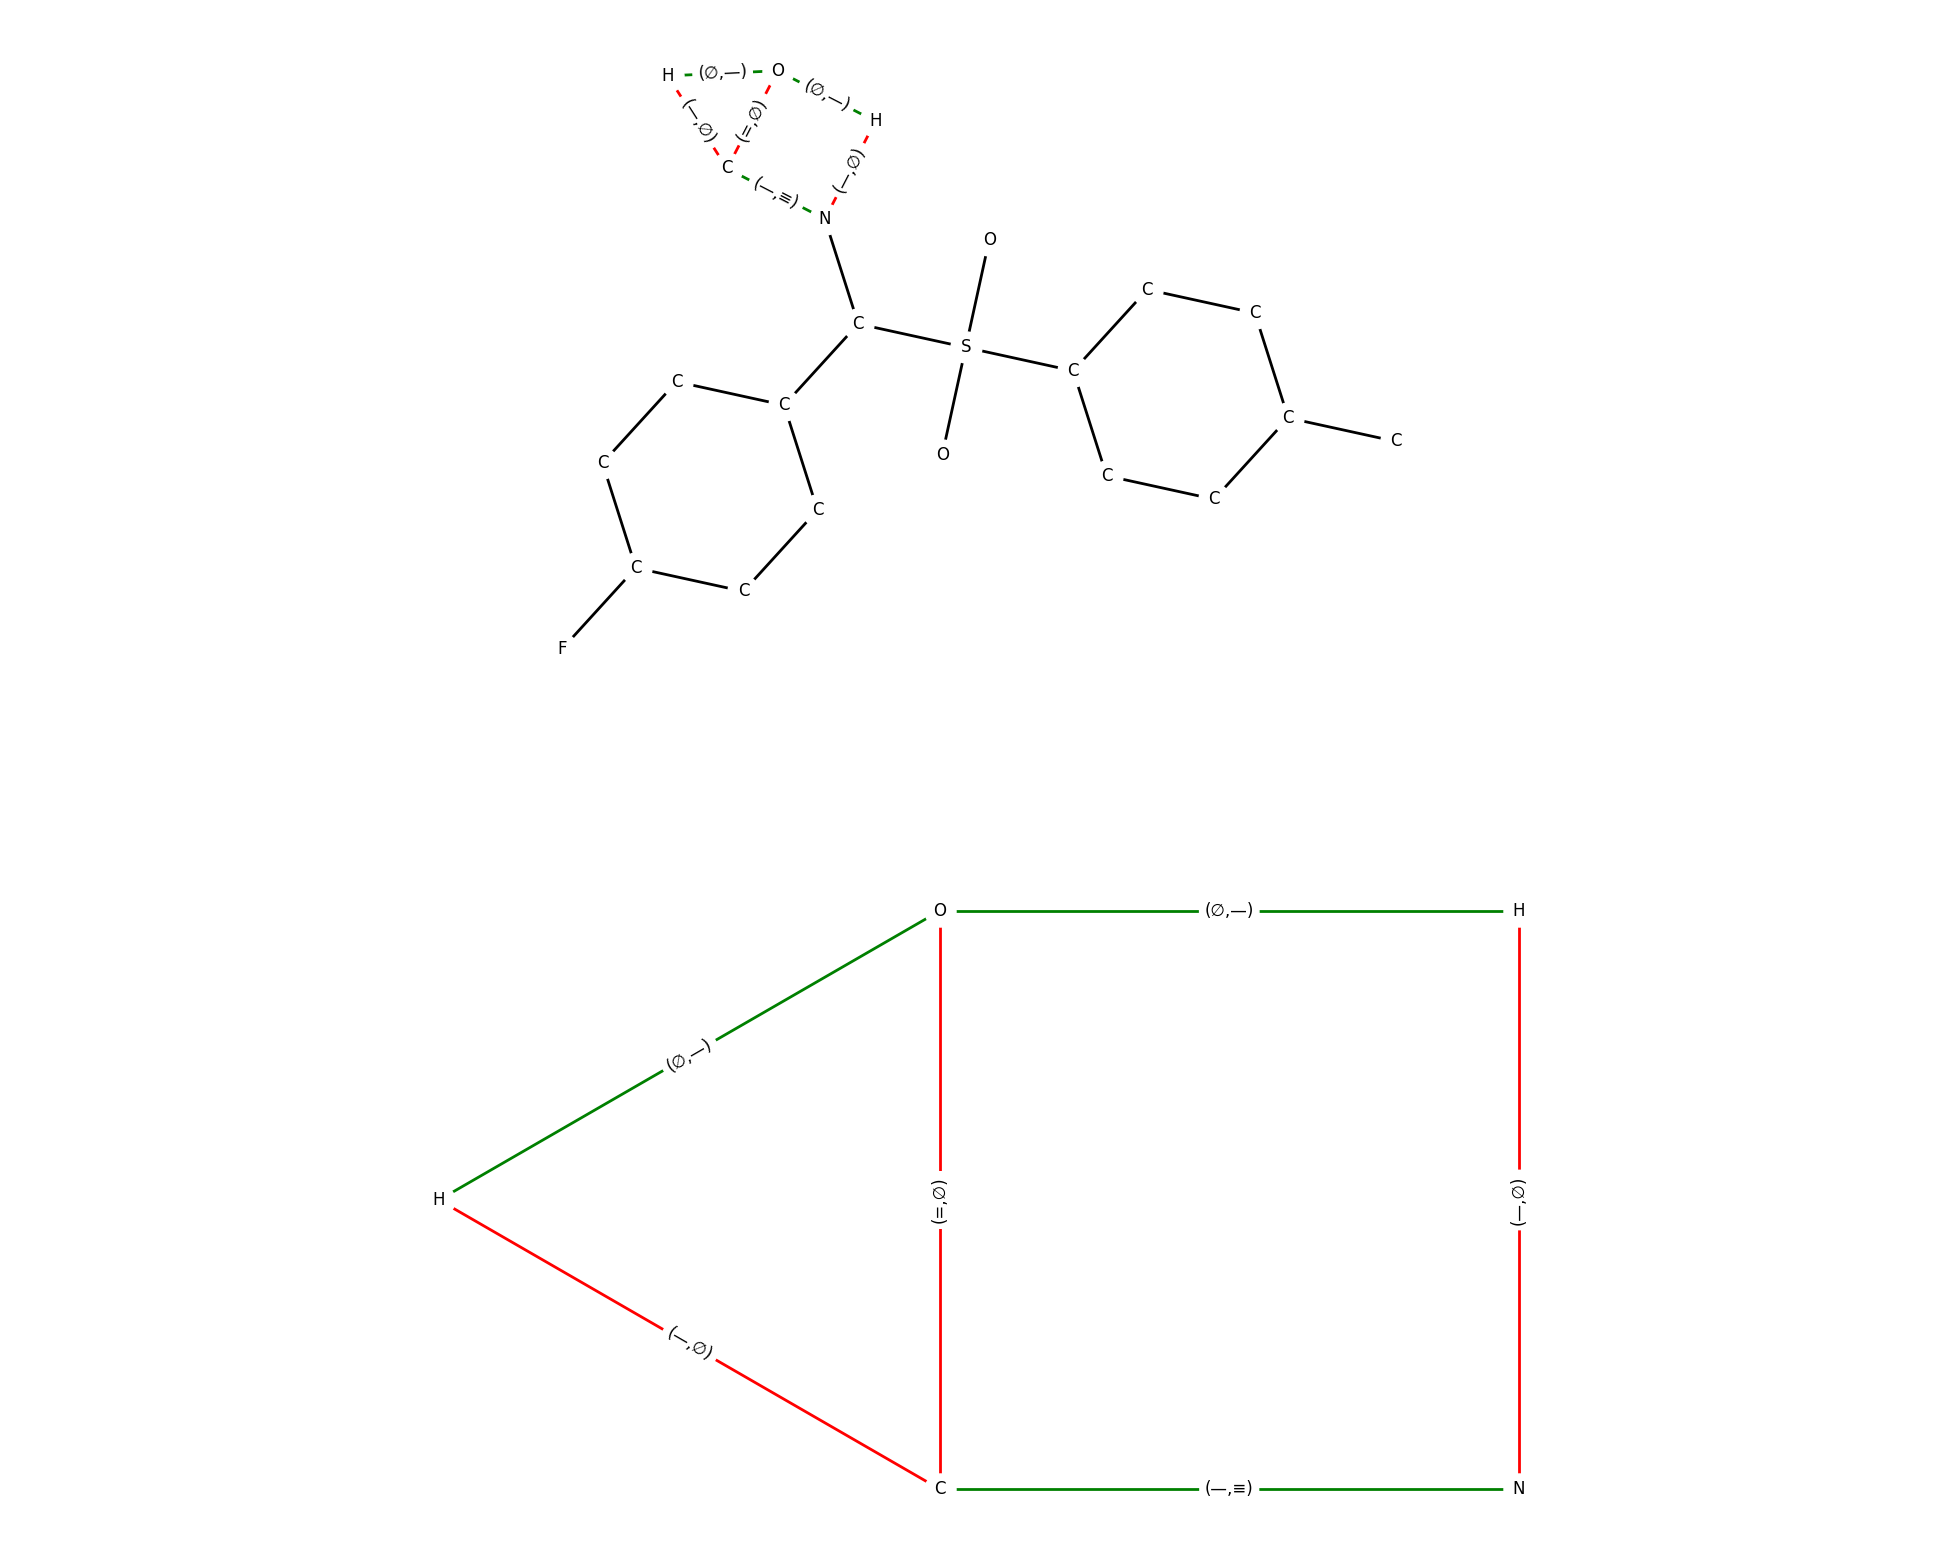

In [41]:
from visualize_graph import visualize_graph

current_partition = partitions[0]

visualize_graph(current_partition[0], with_reaction_center=True)
visualize_graph(current_partition[1], with_reaction_center=True)

# multistage invariant partitioning / hierarchical clustering

In [73]:
invariant_config = {
    0: edge_count_invariant,
    1: vertex_degree_invariant,
    2: weisfeiler_lehman_invariant 
}

invariant_config = {
    0: vertex_count_invariant,
    1: edge_count_invariant,
    2: vertex_degree_invariant,
    3: rank_invariant,
    4: weisfeiler_lehman_invariant 
}

In [74]:
def create_partitions(reactions):
    partitions = []

    for reaction_its in reactions:
        reaction_center = get_reaction_center(reaction_its)
        invariant_partition_index = can_find_partition_by_invariant(partitions, reaction_center, invariant_check_function)

        if type(invariant_partition_index) is int:
            partitions[invariant_partition_index].append(reaction_its)
        else:
            partitions.append([reaction_its])
    
    return partitions

for invariant_index in range(0, len(invariant_config.values())):
    
    invariant_check_function = invariant_config[invariant_index]

    if invariant_index == 0:
        partitions = create_partitions(reactions)
    else:
         for index, partition in enumerate(partitions):
            del partitions[index]
            
            sub_partitions = create_partitions(partition)

            partitions = partitions + sub_partitions

    print(f"{invariant_index}'s partition length = {len(partitions)}")


    

0's partition length = 12
1's partition length = 26
2's partition length = 47
3's partition length = 69
4's partition length = 239
